In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt


import pandas as pd
from sklearn.preprocessing import OneHotEncoder


# STEP 5: Stores information

- New Strategy: create a model for each product

<hr/>

In [4]:
stores_info = pd.read_csv('./Data/kaggle/stores.csv.gz')
df_train =  pd.read_csv('./Data/step4/df_train.csv')
df_test =  pd.read_csv('./Data/step4/df_test.csv')
df_submission =  pd.read_csv('./Data/step4/df_submission.csv')


### Feature Engineering and Analysis

In [5]:
df_train = df_train.merge(stores_info, how='left', on='store_nbr')
df_test = df_test.merge(stores_info, how='left', on='store_nbr')
df_submission = df_submission.merge(stores_info, how='left', on='store_nbr')

In [10]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day_of_week,in_store_list,...,is_Regional_holiday,is_Local_holiday_real,is_Regional_holiday_real,dcoilwtico,first_pay_day,second_pay_day,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday,1,...,0,0,0,93.14,0.0,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,Tuesday,0,...,0,0,0,93.14,0.0,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,Tuesday,1,...,0,0,0,93.14,0.0,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,Tuesday,1,...,0,0,0,93.14,0.0,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,Tuesday,1,...,0,0,0,93.14,0.0,0.0,Quito,Pichincha,D,13


#### Check if the cluster contains the info of State and City

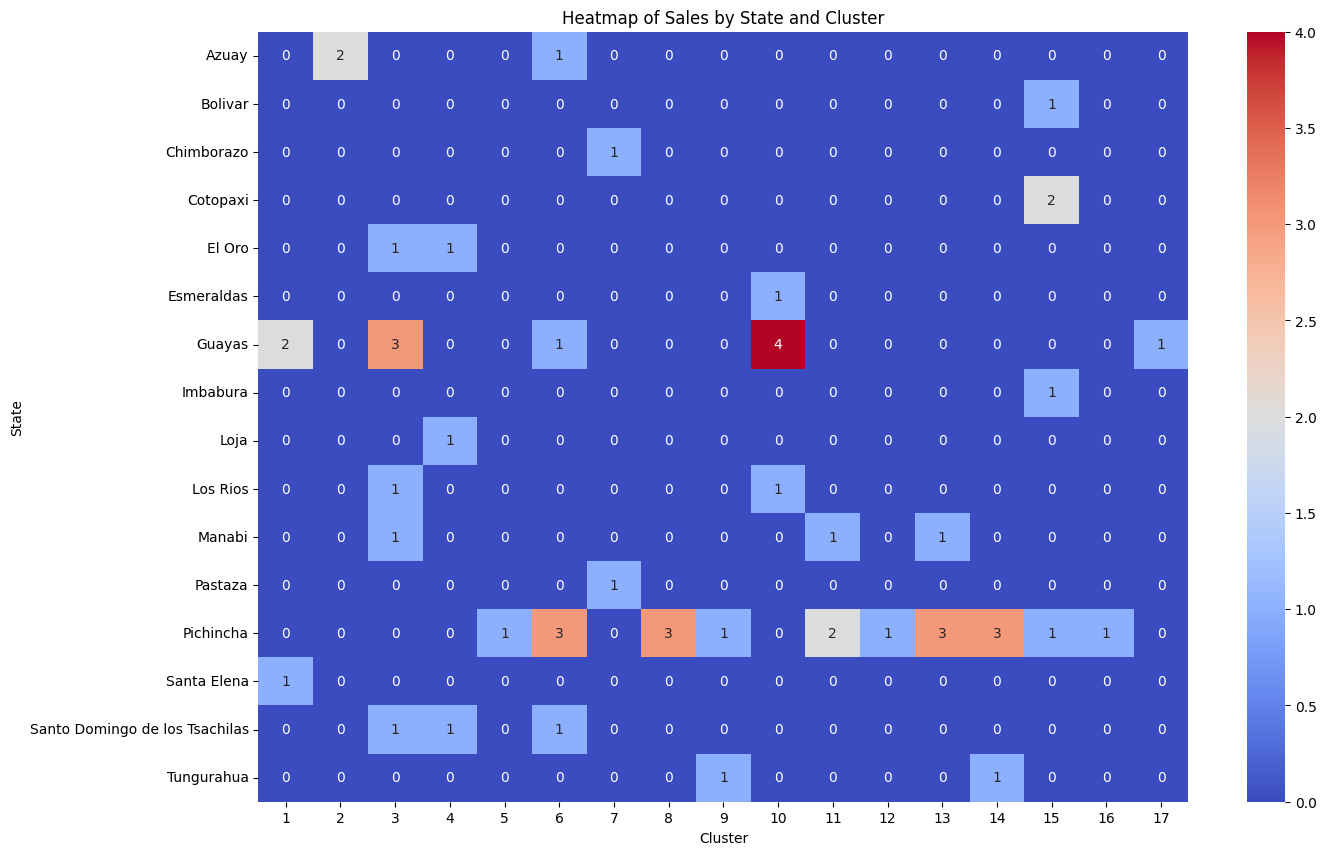

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.crosstab(stores_info['state'], stores_info['cluster']), annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Sales by State and Cluster')
plt.xlabel('Cluster')
plt.ylabel('State')
plt.show()

- In general, the states seem to be isolated in clusters with the Pichincha state being an exception and appearing in several clusters

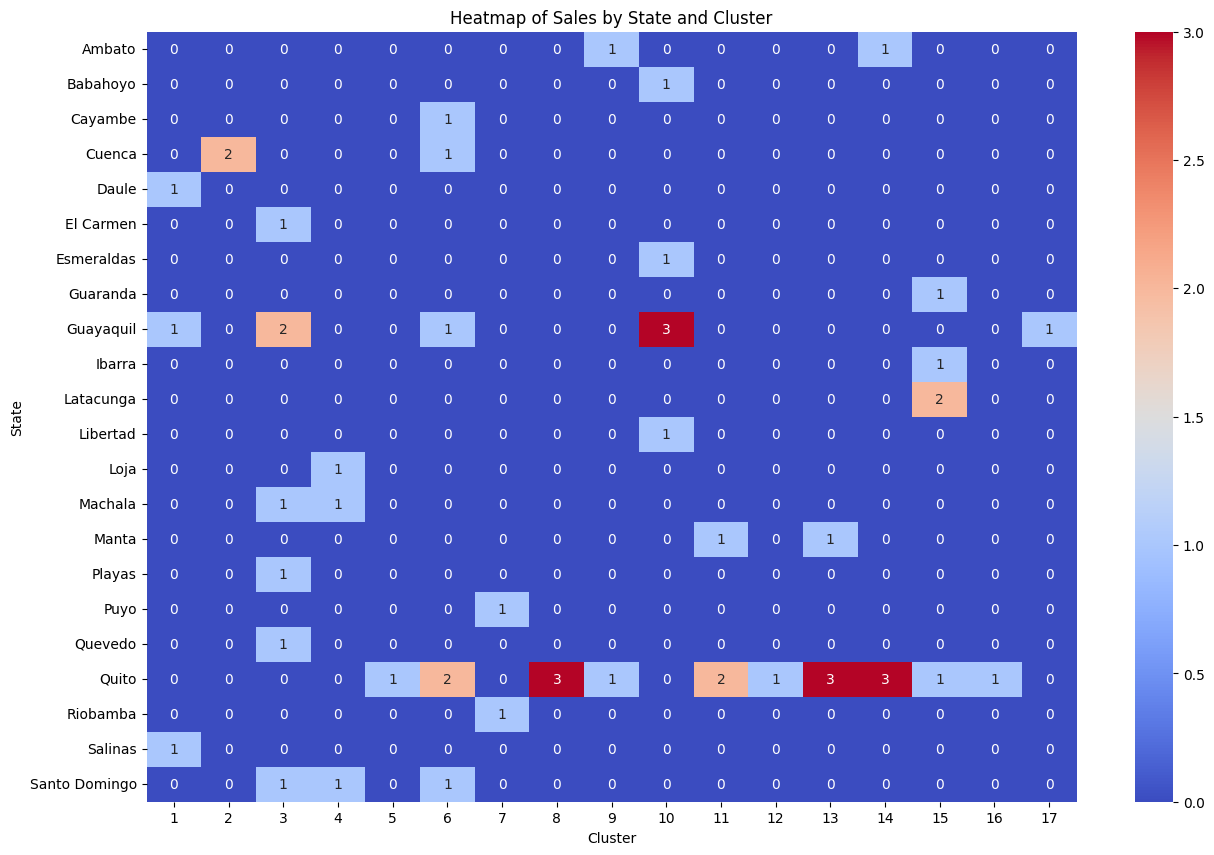

In [15]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.crosstab(stores_info['city'], stores_info['cluster']), annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Sales by State and Cluster')
plt.xlabel('Cluster')
plt.ylabel('State')
plt.show()



- The same goes for cities, with Quito and Guayaquil appearing in more clusters than usual

#### Check the relationship between clusters, type, city and state with the sales

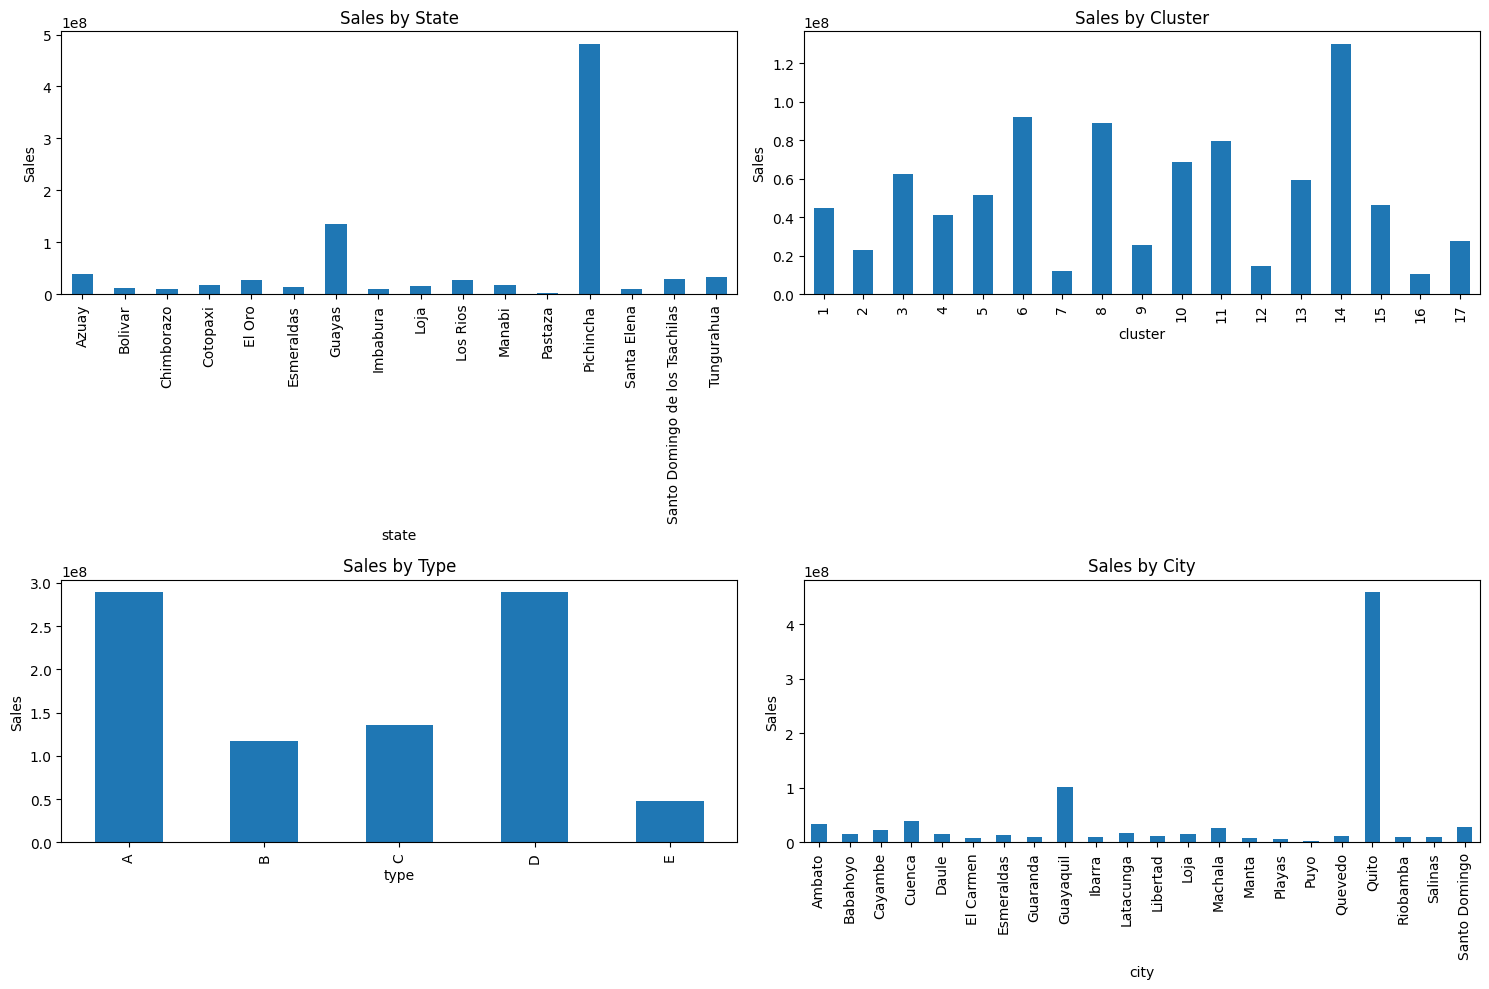

In [12]:
# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sales_by_state = df_train.groupby('state')['sales'].sum()
sales_by_cluster = df_train.groupby('cluster')['sales'].sum()
sales_by_type = df_train.groupby('type')['sales'].sum()
sales_by_city = df_train.groupby('city')['sales'].sum()


sales_by_state.plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Sales by State')
axs[0, 0].set_ylabel('Sales')

sales_by_cluster.plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Sales by Cluster')
axs[0, 1].set_ylabel('Sales')

sales_by_type.plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Sales by Type')
axs[1, 0].set_ylabel('Sales')

sales_by_city.plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Sales by City')
axs[1, 1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

- 2 cities and 2 states stand out in the number of sales
- type A and D stores sell more

### Encode and Generate Sets

In [23]:
train_cols = ['family', 'onpromotion', 'year', 'month', 'day_of_week', 'in_store_list', 'day_off_store']

holiday_cols = ['is_National_holiday', 'day_after_national_holiday',
       'day_before_national_holiday', 'is_Local_holiday',
       'is_Regional_holiday', 'is_Local_holiday_real',
       'is_Regional_holiday_real']

oil_cols = ['dcoilwtico']



pay_cols = ['first_pay_day', 'second_pay_day']

In [38]:
X_train_1, y_train = df_train[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'city', 'state', 'type']], df_train['sales']
X_test_1, y_test = df_test[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'city', 'state', 'type']], df_test['sales']
X_submission_1 = df_submission[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'city', 'state', 'type'] + ['id']]

- Set with all columns and all stores columns

In [39]:
X_train_2, y_train = df_train[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'state', 'type']], df_train['sales']
X_test_2, y_test = df_test[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'state', 'type']], df_test['sales']
X_submission_2 = df_submission[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster',  'state', 'type'] + ['id']]

- Set with all columns and all just cluster, type and state

In [40]:
X_train_3, y_train = df_train[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'type']], df_train['sales']
X_test_3, y_test = df_test[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'type']], df_test['sales']
X_submission_3 = df_submission[train_cols + holiday_cols + oil_cols + pay_cols + ['store_nbr', 'cluster', 'type'] + ['id']]

- Set with all columns and just cluster and type

In [41]:

def encode_one_how(X_train, X_test, X_submission, categorical_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(X_train[categorical_cols])

    # Transform the training and test data
    train_encoded_array = encoder.transform(X_train[categorical_cols])
    test_encoded_array = encoder.transform(X_test[categorical_cols])
    submission_encoded_array = encoder.transform(X_submission[categorical_cols])
    

    # Create DataFrames with the encoded data
    train_encoded_df = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    test_encoded_df = pd.DataFrame(test_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    submission_encoded_df = pd.DataFrame(submission_encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X_submission.index)
    

    # Concatenate the original DataFrame (excluding the original categorical columns) with the encoded DataFrame
    X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols), train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols), test_encoded_df], axis=1)
    X_submission_encoded = pd.concat([X_submission.drop(columns=categorical_cols), submission_encoded_df], axis=1)
    
    return X_train_encoded, X_test_encoded, X_submission_encoded
        

In [42]:
X_train_1, X_test_1, X_submission_1 = encode_one_how(X_train_1, X_test_1, X_submission_1, ['store_nbr', 'month', 'day_of_week', 'cluster', 'city', 'state', 'type'])

In [43]:
X_train_2, X_test_2, X_submission_2 = encode_one_how(X_train_2, X_test_2, X_submission_2, [ 'store_nbr', 'month', 'day_of_week', 'cluster', 'state', 'type'])


In [44]:
X_train_3, X_test_3, X_submission_3 = encode_one_how(X_train_3, X_test_3, X_submission_3, [ 'store_nbr', 'month', 'day_of_week', 'cluster',  'type'])


In [45]:
X_train_1.shape, X_test_1.shape, X_submission_1.shape

((2603502, 148), (404514, 148), (28512, 149))

In [46]:
X_train_2.shape, X_test_2.shape, X_submission_2.shape

((2603502, 126), (404514, 126), (28512, 127))

In [47]:
X_train_3.shape, X_test_3.shape, X_submission_3.shape

((2603502, 110), (404514, 110), (28512, 111))

### Models Evaluation

In [48]:
# Train and evaluate model for each store
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)



#### Compare Models and Training Sets - One Store Prediction

In [49]:
# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': GradientBoostingRegressor(random_state=42)
}

sets = {
    'Train with all columns + stores cluster, city, state, type': [
        X_train_1[X_train_1['family'] == 'GROCERY I'].drop(columns='family'), 
        y_train[X_train_1['family'] == 'GROCERY I'], 
        X_test_1[X_test_1['family'] == 'GROCERY I'].drop(columns='family'), 
        y_test[X_test_1['family'] == 'GROCERY I']
    ],
    'Train with all columns + stores cluster, state, type': [
        X_train_2[X_train_2['family'] == 'GROCERY I'].drop(columns='family'), 
        y_train[X_train_2['family'] == 'GROCERY I'], 
        X_test_2[X_test_2['family'] == 'GROCERY I'].drop(columns='family'), 
        y_test[X_test_2['family'] == 'GROCERY I']
    ],
     'Train with all columns + stores cluster, type': [
        X_train_3[X_train_3['family'] == 'GROCERY I'].drop(columns='family'), 
        y_train[X_train_3['family'] == 'GROCERY I'], 
        X_test_3[X_test_3['family'] == 'GROCERY I'].drop(columns='family'), 
        y_test[X_test_3['family'] == 'GROCERY I']
    ]
}
def evaluate_models(models, sets):
    results = []

    for set_name, data in sets.items():
        X_train, y_train, X_test, y_test = data
        
        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)
            
            # Predict on the test set
            y_pred = model.predict(X_test)
            y_pred[y_pred < 0] = 0
            # Calculate Mean Squared Error
            score = rmsle(y_test, y_pred)
            
            # Append results
            results.append({
                'Set': set_name,
                'Model': model_name,
                'RMSLE': score
            })
    return pd.DataFrame(results)

In [50]:
results = evaluate_models(models, sets)
results

,Set,Model,RMSLE
0,"Train with all columns + stores cluster, city,...",RandomForest,0.890513
1,"Train with all columns + stores cluster, city,...",XGBoost,0.637035
2,"Train with all columns + stores cluster, state...",RandomForest,0.890703
3,"Train with all columns + stores cluster, state...",XGBoost,0.637035
4,"Train with all columns + stores cluster, type",RandomForest,0.895470
5,"Train with all columns + stores cluster, type",XGBoost,0.681415


In [51]:
results.to_csv('./Data/step5/results.csv')

#### Create a model for each Product

In [52]:


def train_per_prudct(X_train, y_train, X_test, y_test):
    all_y_true_rf = []
    all_y_true_gb = []
    
    all_y_pred_rf = []
    all_y_pred_gb = []
    models = {}
    products = X_train['family'].unique()

    for prod in products:
        print('product', prod)
        X_train_st = X_train[X_train['family'] == prod].drop(columns=['family'])
        X_test_st = X_test[X_test['family'] == prod].drop(columns=['family'])
        
        y_train_st = y_train[X_train['family'] == prod]
        y_test_st = y_test[X_test['family'] == prod]
        
        # Train Random Forest Regressor
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_rf = rf.predict(X_test_st)
        y_pred_rf[y_pred_rf < 0] = 0
        # Append true values and predictions to the lists
        all_y_true_rf.extend(y_test_st)
        all_y_pred_rf.extend(y_pred_rf)
        
        gb = GradientBoostingRegressor(random_state=42)
        gb.fit(X_train_st, y_train_st) 
        # Make predictions
        y_pred_gb = gb.predict(X_test_st)
        y_pred_gb[y_pred_gb < 0] = 0
        # Append true values and predictions to the lists
        all_y_true_gb.extend(y_test_st)
        all_y_pred_gb.extend(y_pred_gb)
        
        models[prod] = {
            'rf': rf,
            'gb': gb
        }
    
    total_rmsle_rf = rmsle(np.array(all_y_true_rf), np.array(all_y_pred_rf))
    total_rmsle_gb = rmsle(np.array(all_y_true_gb), np.array(all_y_pred_gb))

    return {
        'Random Forest': total_rmsle_rf,
        'XGBoost': total_rmsle_gb,
        'models': models
    }
        
def predict_per_product(models, X_submission, model_name='rf'):
    products = X_submission['family'].unique()
    predictions = {'id': [], 'sales': []}
    for prod in products:
        X_submission_st = X_submission[X_submission['family'] == prod]
        ids = X_submission_st['id']
        X_submission_st = X_submission_st.drop(columns=['id', 'family'])
        y_pred = models[prod][model_name].predict(X_submission_st)
        y_pred[y_pred < 0] = 0
        predictions['id'] += list(ids)
        predictions['sales'] += list(y_pred)
        
    predictions_df = pd.DataFrame(predictions)
    return predictions_df
        


In [53]:
stores = df_train['store_nbr'].unique()
result = train_per_prudct(X_train_1, y_train, X_test_1, y_test)
print('RMLSE Random Forest', result['Random Forest'])
print('RMLSE XGBoost', result['XGBoost'])


product AUTOMOTIVE
product BABY CARE
product BEAUTY
product BEVERAGES
product BOOKS
product BREAD/BAKERY
product CELEBRATION
product CLEANING
product DAIRY
product DELI
product EGGS
product FROZEN FOODS
product GROCERY I
product GROCERY II
product HARDWARE
product HOME AND KITCHEN I
product HOME AND KITCHEN II
product HOME APPLIANCES
product HOME CARE
product LADIESWEAR
product LAWN AND GARDEN
product LINGERIE
product LIQUOR,WINE,BEER
product MAGAZINES
product MEATS
product PERSONAL CARE
product PET SUPPLIES
product PLAYERS AND ELECTRONICS
product POULTRY
product PREPARED FOODS
product PRODUCE
product SCHOOL AND OFFICE SUPPLIES
product SEAFOOD
RMLSE Random Forest 0.6670062321457286
RMLSE XGBoost 0.6595421625121582


In [58]:
last_submission_df = predict_per_product(result['models'], X_submission_1, model_name='gb')
last_submission_df.to_csv('./Data/submssions/submission_step5.csv', index=False)